CNNs, ResNets and LR-Scheduling

### Topics

In this notebook, I cover the following topics
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling
- [learn about transfer learning]


### Imports

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import os
import numpy as np
from torchsummary import summary
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time
import seaborn as sns

## 1. Setup

You can use the functions to grab the data, split the sets and create the dataloaders, etc. given to you at exercise sheet 2.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you work with Colab (which is recommended) you have to mount the drive first and create a path to your python module.

#### **TODO**
Create a file named 'utils.py' and import it here. You can import any package necessary.

In [2]:
import utils

## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of 'utils.py' to instantiate the train-, test- and validation datasets along with their dataloaders.

In [3]:
# TODO define device
device = utils.get_device()

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla K80


In [4]:
data_dir = './data'  
batch_size = 256

# TODO grab data, generate split, init data loaders
trainset, testset, dataset_mean, dataset_std = utils.grab_data(data_dir=data_dir)
trainset, valset = utils.generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2)
trainloader, valloader, testloader = utils.init_data_loaders(trainset, valset, testset, batch_size=batch_size)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


#### **TODO** 
Define the loss function. We use the cross entropy loss again.

In [5]:
# TODO define loss function
loss_function = nn.CrossEntropyLoss()

## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture. 
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

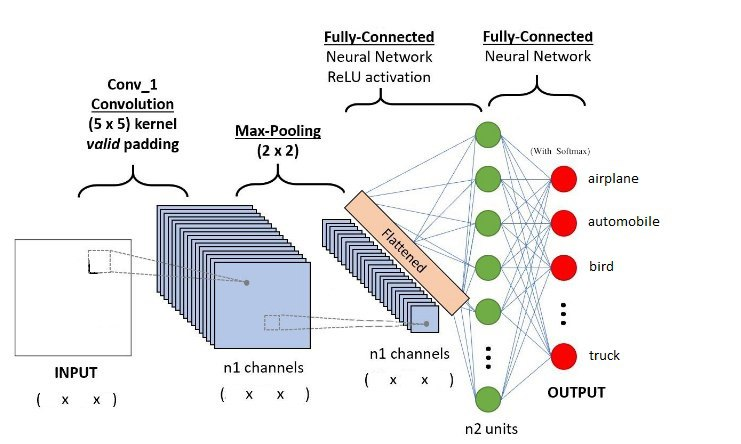

#### **Remarks**

- **batch_size, num_channels, img_width, img_width = torch.Size([256, 3, 32, 32])**
- **(img_width - (kernel_size-1))^2 x out_channels = (28 x 28) x 32 under "valid padding"**
- **(28/2 x 28/2) x 32 = (14 x 14) x 32**
- **n1 = 32, n2 = (14 x 14) x 32**
- **kernel_size^2 x in_channels x out_channels = (5 x 5) x 3 x 32 = 2400**, compare DL_04_CNN p.61

In [6]:
# Dimensions
_, num_channels, _, img_width = next(iter(trainloader))[0].shape
num_classes = len(trainset.dataset.classes)

**Your answers here**

In [ ]:
# Define model
class CNN_1(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(CNN_1, self).__init__()
        self.model = self.create_model(num_channels, num_classes)
    def create_model(self, num_channels, num_classes):
        model = nn.Sequential(
                              nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=5, stride=1),
                              nn.MaxPool2d(kernel_size=2),
                              nn.ReLU(),
                              nn.Flatten(),
                              nn.Linear(in_features=14*14*32, out_features=512),
                              nn.ReLU(),
                              nn.Linear(in_features=512, out_features=num_classes),
                              nn.Softmax()
                              )
        return model




#### **TODO**

- Train the model for 10 epochs. Use a learning rate of 0.001.
- Plot the results of accuracy and loss as you did in exercise sheet 2.

In [ ]:
# Set hyperparameters
lr = 1e-3  # learning rate
num_epochs = 10  # number of epochs
device

# Initialize
model_1a     = CNN_1(num_channels=num_channels, num_classes=num_classes).model
model_1a.to(device)
optimizer_1a = optim.Adam(model_1a.parameters(), lr=lr)


summary(model_1a, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]           2,432
         MaxPool2d-2           [-1, 32, 14, 14]               0
              ReLU-3           [-1, 32, 14, 14]               0
           Flatten-4                 [-1, 6272]               0
            Linear-5                  [-1, 512]       3,211,776
              ReLU-6                  [-1, 512]               0
            Linear-7                   [-1, 10]           5,130
           Softmax-8                   [-1, 10]               0
Total params: 3,219,338
Trainable params: 3,219,338
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.34
Params size (MB): 12.28
Estimated Total Size (MB): 12.64
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
# Fit the Model: training and validation
train_losses, val_losses, train_accs, val_accs, confusion_matrix = utils.run_training(model=model_1a, 
                                                                                      optimizer=optimizer_1a, 
                                                                                      loss_function=loss_function, 
                                                                                      device=device, 
                                                                                      num_epochs=num_epochs, 
                                                                                      train_dataloader=trainloader, 
                                                                                      val_dataloader=valloader, 
                                                                                      early_stopper=None, 
                                                                                      verbose=False)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Finished training after 184 seconds.


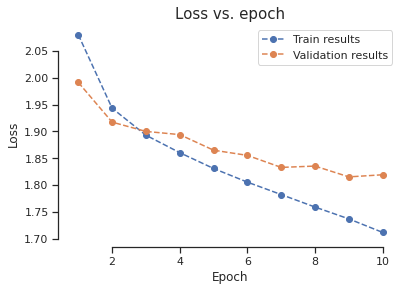

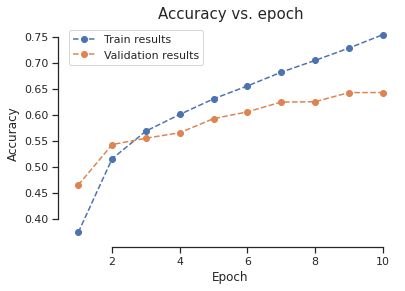

max_val_acc: 0.6431


In [ ]:
# Plot the training curves of the loss and the accuracies
utils.plot(title="Loss vs. epoch",     label="Loss",     train_results=train_losses, val_results=val_losses)
utils.plot(title="Accuracy vs. epoch", label="Accuracy", train_results=train_accs,   val_results=val_accs)
print(f"max_val_acc: {max(val_accs)}")

#### **TODO**
Compare results to MLP. What can you observe?

- **In contrast to the MLP, the CNN1 has an immediately better perfomance (smaller losses, higher accuracies), which persists over the epoches.**
- **Similar to the MLP, CNN1's validation accuracy reaches a plateau after a small number of epoches (7 in this example).**

#### **TODO** 
Train longer (ca. 60 epochs), plot again.

In [ ]:
# Set hyperparameters
num_epochs = 40  # number of epochs (a bit smaller than suggested...)
lr = 1e-3  # learning rate
# Initialize
model_1b     = CNN_1(num_channels=num_channels, num_classes=num_classes).model
model_1b.to(device)
optimizer_1b = optim.Adam(model_1b.parameters(), lr=lr)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
            Conv2d-3           [-1, 32, 14, 14]           9,248
       BatchNorm2d-4           [-1, 32, 14, 14]              64
            Conv2d-5           [-1, 32, 14, 14]           9,248
       BatchNorm2d-6           [-1, 32, 14, 14]              64
     ResidualBlock-7           [-1, 32, 14, 14]               0
            Conv2d-8           [-1, 32, 14, 14]           9,248
       BatchNorm2d-9           [-1, 32, 14, 14]              64
           Conv2d-10           [-1, 32, 14, 14]           9,248
      BatchNorm2d-11           [-1, 32, 14, 14]              64
    ResidualBlock-12           [-1, 32, 14, 14]               0
           Conv2d-13             [-1, 64, 7, 7]          18,496
      BatchNorm2d-14             [-1, 6

In [ ]:


# Fit the Model: training and validation
train_losses, val_losses, train_accs, val_accs, confusion_matrix = utils.run_training(model=model_1b, 
                                                                                      optimizer=optimizer_1b, 
                                                                                      loss_function=loss_function, 
                                                                                      device=device, 
                                                                                      num_epochs=num_epochs, 
                                                                                      train_dataloader=trainloader, 
                                                                                      val_dataloader=valloader, 
                                                                                      early_stopper=None, 
                                                                                      verbose=False)


cuda:0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Finished training after 726 seconds.


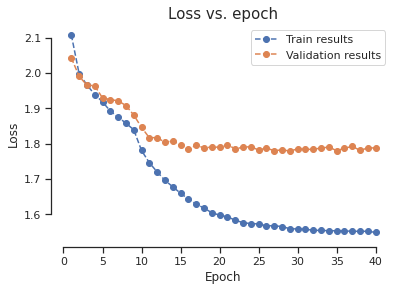

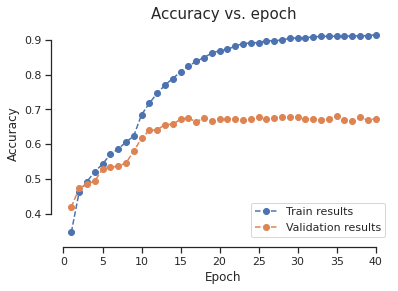

max_val_acc: 0.6805


In [ ]:
# Plot the training curves of the loss and the accuracies
utils.plot(title="Loss vs. epoch",     label="Loss",     train_results=train_losses, val_results=val_losses)
utils.plot(title="Accuracy vs. epoch", label="Accuracy", train_results=train_accs,   val_results=val_accs)
print(f"max_val_acc: {max(val_accs)}")

#### **Questions**
- Why is that not an optimal model?
- What could be improved?

- **The additional epochs do not improve CNN1's validation accuracy (at least visibly), but take further computation time.**
- **The train loss reaches 0 after ca 20 epochs, but the validation loss increases above the initialized, untrained CNN1. This suggests overfitting.**
- **We should consider an early stopping within 10 epochs.**
- **The lecture hints at adding more convolutional layers, which may further justify a smaller number of dimension for the hidden linear layer(s), too.**

## 4. CNN model with more convolutional layers

#### **TODO**
Define the architecture displayed in the graphic.

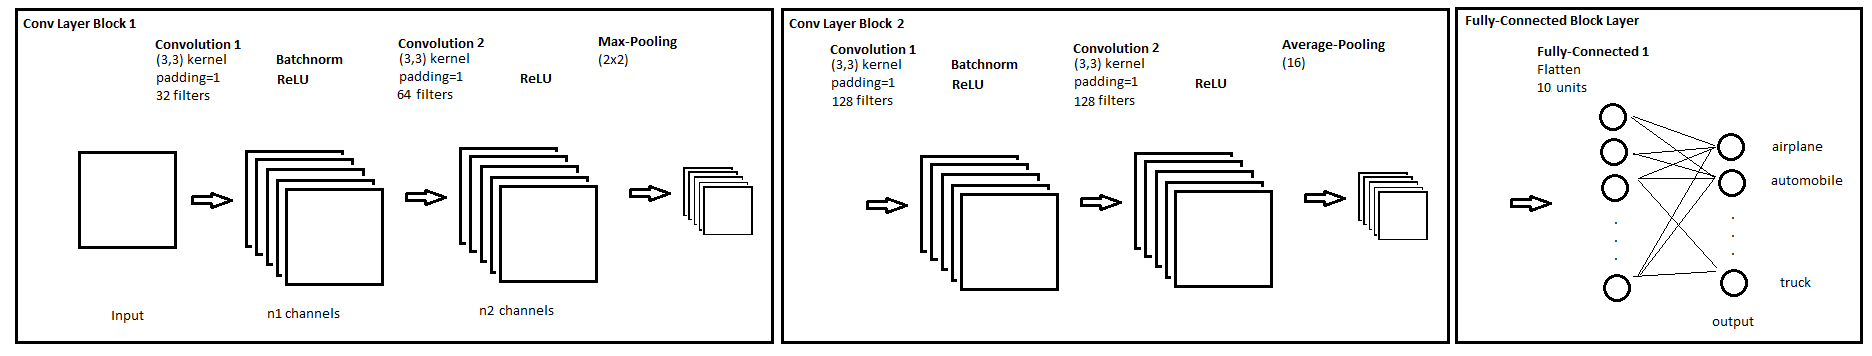

#### **Questions**

- (1) Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?
- (2) What does padding=1 mean in the case of the network displayed above?
- (3) What are the dimensions of the feature maps after the 1. conv layer?
- (4) What are the dimensions of the feature maps after the 2. conv layer?
- (5) What ist the receptive field size after the first two convolutions?
- (6) What is the value for the in_features for the fully-connected layer?
- (7) What is the number of parameters of *Conv Layer block 1*?

**Your answers here**
- (1) **Valid padding** reduces a feature map by k-1 pixels in each dimension after a convolution with a (k x k) kernel. **Same padding** keeps the size of the feature map in each dimension (see DL_04_CNN, p.62).
- (2) **padding=1** "Padding added to all four sides of the input." Using this specification, it is a frame with 1 zero-pixel on each of the four sides. The (32+2) x (32+2) padded images shrink by 3-1 pixels to their initial dimensions (32 x 32).
- (3) Dimensions of the feature maps after the 1. conv layer: **(32 x 32) pixels x 32 maps**
- (4) Dimensions of the feature maps after the 2. conv layer: **(32 x 32) pixels x 64 maps** (Note that convolution with same padding and batch norm do not affect the initial image dimensions.)
- (5) Size of receptive field after the first two convolutions: Using default 'stride=1', **RF size = 1 + (3-1) + (3-1) = 5** (see DL_04_CNN, p.64).
- (6) Value for the in_features for the fully-connected layer: **flattened (1 x 1) x 128 channels** since maps of (32 x 32) reduce to (16 x 16) by Max-Pooling and further to (1 x 1) by Average-Pooling.
- (7) Parameters which stem from the two layers of filters: **(3 x 3) kernel x 3 in_channels x 32 out_channels + (3 x 3) kernel x 32 in_channels x 64 out_channels = 19296**

In [ ]:
# Define model 2
class CNN_2(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(CNN_2, self).__init__()
        ## Conv Layer Block 1 ##
        self.conv11 = nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=3, padding=1)  # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.bnorm1 = nn.BatchNorm2d(num_features=32)  # https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
        self.conv12 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.mpool1 = nn.MaxPool2d(kernel_size=2)
        
        ## Conv Layer Block 2 ##
        self.conv21 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bnorm2 = nn.BatchNorm2d(num_features=128)
        self.conv22 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.apool2 = nn.AvgPool2d(kernel_size=16)  # https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html
        
        ## Fully-Connected Block Layer ##
        self.l_out  = nn.Linear(in_features=128, out_features=num_classes)

    def forward (self, x):
        ## Conv Layer Block 1 ##
        x = F.relu(self.bnorm1(self.conv11(x)))
        x = F.relu(self.mpool1(self.conv12(x)))
        
        ## Conv Layer Block 2 ##
        x = F.relu(self.bnorm2(self.conv21(x))) 
        x = F.relu(self.apool2(self.conv22(x)))
        
        ## Fully-Connected Block Layer ##
        x = torch.flatten(x, start_dim=1, end_dim=-1) 
        x = self.l_out(x)
        return x


#### **TODO** 

- train the new net (30 epochs, lr=0.1), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results: 
-**(1) The initializing parameters are far away from the minimum loss. This is immediately corrected after the first epoch, but training and validation loss then remain rather constant.**
-**(2) The learning rate is to high such that the iterative model fitting jumps across the loss minimum. This is at least somehow reflected in the accuracy plot.**

In [ ]:
# Set hyperparameters
lr = 1e-1  # learning rate
num_epochs = 15  # number of epochs (a bit smaller than suggested...)

# Initialize
model_2     = CNN_2(num_channels=num_channels, num_classes=num_classes)
model_2.to(device)
optimizer_2 = optim.Adam(model_2.parameters(), lr=lr)
loss_fct_2  = nn.CrossEntropyLoss()

# Fit the Model: training and validation
train_losses, val_losses, train_accs, val_accs, confusion_matrix = utils.run_training(model=model_2, 
                                                                                      optimizer=optimizer_2, 
                                                                                      loss_function=loss_fct_2, 
                                                                                      device=device, 
                                                                                      num_epochs=num_epochs, 
                                                                                      train_dataloader=trainloader, 
                                                                                      val_dataloader=valloader, 
                                                                                      early_stopper=None, 
                                                                                      verbose=False)


Finished training after 558 seconds.


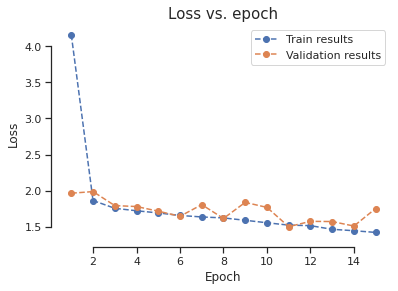

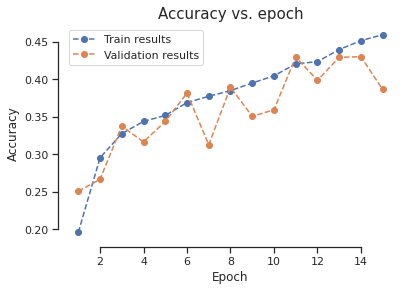

max_val_acc: 0.4299


In [ ]:
# Plot the training curves of the loss and the accuracies
utils.plot(title="Loss vs. epoch",     label="Loss",     train_results=train_losses, val_results=val_losses)
utils.plot(title="Accuracy vs. epoch", label="Accuracy", train_results=train_accs,   val_results=val_accs)
print(f"max_val_acc: {max(val_accs)}")

## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*. 
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

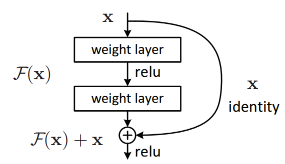

#### **Questions**
- Which problems do using skip connections solve? 
-**vanishing gradient**
- Why is a residual network called residual?  
-**Because we learn/optimize the residual function F(x) = H(x) - x**
- When is the advantage of ResNets over 'normal' CNNs most visible? with very deep networks
-**For deep networks**

**Your answers here**

#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model
- train the model
- plot results

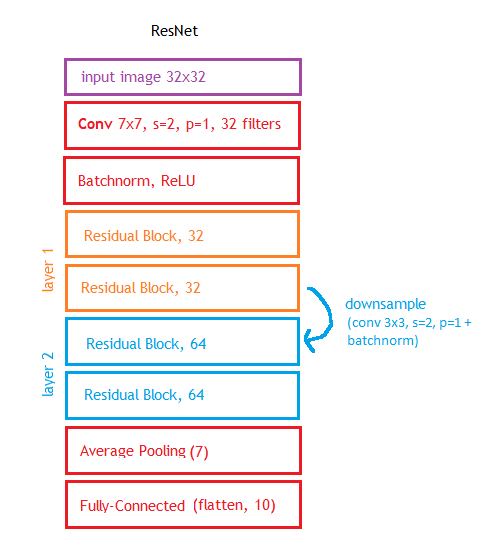 
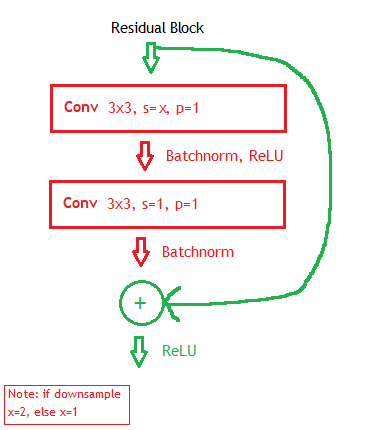

**Hints**

- The downsampling in this ResNet happens between layer 1 and layer 2. In this step, the channel size is increased (32 -> 64) and the image resolution is downsampled by strided convolution (stride=2 in the Conv2d layers).
- For the adding part, the dimensions obviously have to be the same. This is accomplished by using stride=2 in the first Conv2d layer of the block while the second layer does not change the dimensions.
- The average-pooling layer has kernel size 7.
- For you to ensure everything works fine, here are the shapes in the form [(batchsize), x, y, channel] where I discard batchsize, because it does not change.
32x32x3 -> conv 7x7 -> 14x14x32 -> layer 1 -> 14x14x32 -> layer2 -> 7x7x64 -> avpool(7) -> 1x1x64 -> linear(64, 10)

In [8]:
# TODO write a class ResidualBlock(nn.Module) where you define the blocks used in the ResNet
class ResidualBlock(nn.Module):
    def __init__(self, num_channels, out_channels, downsample=False):
        super(ResidualBlock, self).__init__()
        self.downsample = downsample
        self.downsample_conv = nn.Conv2d(in_channels=num_channels, out_channels=out_channels, kernel_size=1, stride=2, padding=0)
        if self.downsample:
            self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1)  # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        else:
            self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.bnorm1 = nn.BatchNorm2d(num_features=out_channels)  # https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.bnorm2 = nn.BatchNorm2d(num_features=out_channels)
        #self.mpool1 = nn.MaxPool2d(kernel_size=2)
        

    def forward (self, x):
        y = F.relu(self.bnorm1(self.conv1(x)))
        y = self.bnorm2(self.conv2(y))
        if self.downsample:
            y = y + self.downsample_conv(x)
        else:
            y = y + x
        y = F.relu(y)

        return y

In [9]:
# TODO write a class ResNet(nn.Module) where you define the model
# Define model 2
class ResNet(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=7, stride=2, padding=1)
        self.bnorm = nn.BatchNorm2d(num_features=32)
        self.res_1 = ResidualBlock(32, 32)
        self.res_2 = ResidualBlock(32, 32)
        self.res_3 = ResidualBlock(32, 64, downsample=True)
        self.res_4 = ResidualBlock(64, 64)
        self.apool1 = nn.AvgPool2d(kernel_size=7)
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
        self.l_out  = nn.Linear(in_features=64, out_features=num_classes)

    def forward (self, x):
        x = self.conv1(x)
        x = F.relu(self.bnorm(x))
        x = self.res_1(x)
        x = self.res_2(x)
        x = self.res_3(x)
        x = self.res_4(x)
        x = self.apool1(x)
        x = self.flatten(x)
        x = self.l_out(x)
        return x

In [ ]:
model = ResNet(3, 10)
#input = torch.randn(1, 3, 32, 32)
#x = model.eval()
#x = model(input)
#print(x)
model.to(device)
summary(model, (3, 32, 32))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]           4,736
       BatchNorm2d-2           [-1, 32, 14, 14]              64
            Conv2d-3           [-1, 32, 14, 14]           9,248
       BatchNorm2d-4           [-1, 32, 14, 14]              64
            Conv2d-5           [-1, 32, 14, 14]           9,248
       BatchNorm2d-6           [-1, 32, 14, 14]              64
     ResidualBlock-7           [-1, 32, 14, 14]               0
            Conv2d-8           [-1, 32, 14, 14]           9,248
       BatchNorm2d-9           [-1, 32, 14, 14]              64
           Conv2d-10           [-1, 32, 14, 14]           9,248
      BatchNorm2d-11           [-1, 32, 14, 14]              64
    ResidualBlock-12           [-1, 32, 14, 14]               0
           Conv2d-13             [-1, 64, 7, 7]          18,496
      BatchNorm2d-14             [-1, 6

In [ ]:
# TODO train and plot
# Set hyperparameters
lr = 1e-3  # learning rate
num_epochs = 15  # number of epochs (a bit smaller than suggested...)

# Initialize
model = ResNet(num_channels, num_classes)
model.to(device)
optimizer_res = optim.Adam(model.parameters(), lr=lr)
loss_fct_res  = nn.CrossEntropyLoss()
early_stop = utils.EarlyStopper(patience=5)
# Fit the Model: training and validation
train_losses, val_losses, train_accs, val_accs, confusion_matrix = utils.run_training(model=model, 
                                                                                      optimizer=optimizer_res, 
                                                                                      loss_function=loss_fct_res, 
                                                                                      device=device, 
                                                                                      num_epochs=num_epochs, 
                                                                                      train_dataloader=trainloader, 
                                                                                      val_dataloader=valloader, 
                                                                                      early_stopper=early_stop, 
                                                                                      verbose=False)

Early Stopping!!
Finished training after 313 seconds.


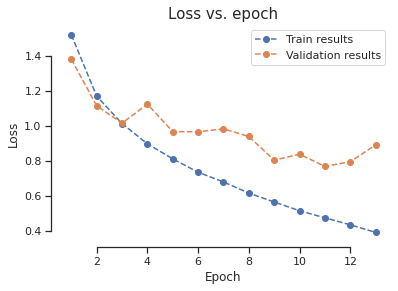

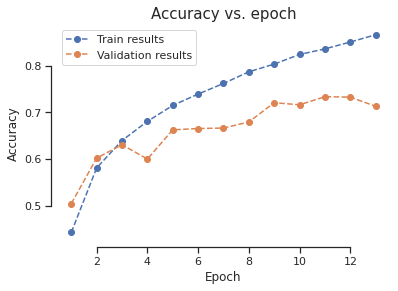

max_val_acc: 0.7334


In [ ]:
# Plot the training curves of the loss and the accuracies
utils.plot(title="Loss vs. epoch",     label="Loss",     train_results=train_losses, val_results=val_losses)
utils.plot(title="Accuracy vs. epoch", label="Accuracy", train_results=train_accs,   val_results=val_accs)
print(f"max_val_acc: {max(val_accs)}")

#### **Questions**
- Does the performance increase compared to the CNNs you trained before? Why/Why not?
-**Yes, the performance improved (68% vs 73%), however, the improvement is not much this is because we did not make ResNet deep enough.**
- Compare the runtime of CNN and ResNet.
-**ResNet has a smaller run time as compared to CNN (part 4)**

**Your answers here**

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*torch.optim.lr_scheduler* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use StepLR (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate? 
    - **decreases lr by *0.1 every epoch**
    - what do you observe regarding performance?
    - **Performance saturates rather quickly, however, it is not the best performance.**
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate? 
    - **decreases lr by *0.9 every epoch**
    - what do you observe regarding performance?
    - **Performance improves but takes more time to saturate.**
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?
- **if we choose a small gamma, the performance saturates rather quickly for small gamma, one should choose a larger step size to imrove scheduling.**

**Your answers here**

In [10]:
# TODO change run_training (you can copy the code from utils.py here and create a new method here 
# or just change/create a new method it in the python file)
def accuracy(correct, total): 
    """Compute accuracy as percentage.

    Args:
        correct (int): Number of samples correctly predicted.
        total (int): Total number of samples

    Returns:
        float: Accuracy
    """
    return float(correct)/total


def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Run one training epoch.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float, float: Mean loss of this epoch, fraction of correct predictions
            on training set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()

        # Forward pass
        y_pred = model(x.to(device))

        # For calculating the accuracy, save the number of correctly classified 
        # images and the total number
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """Compute loss, accuracy and confusion matrix on validation set.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over to draw 
            batches and show validation progress

    Returns:
        float, float, torch.Tensor shape (10,10): Mean loss on validation set, 
            fraction of correct predictions on validation set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill confusion matrix
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] +=1

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), confusion_matrix


def run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader, early_stopper=None, verbose=False, scheduler=None):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        #print(optimizer)
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        if scheduler is not None:
          scheduler.step(epoch_val_acc)

        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if early_stopper:
            early_stopper.update(epoch_val_acc, model)
            if early_stopper.early_stop:
                break
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix

class EarlyStopper:
    """Early stops the training if validation accuracy does not increase after a
    given patience. Saves and loads model checkpoints.
    """
    def __init__(self, patience=0, verbose=False, path='checkpoint'):
        """Initialization.

        Args:
            verbose (bool, optional): Print additional information. Defaults to False.
            path (str, optional): Path where checkpoints should be saved. 
                Defaults to 'checkpoint.pt'.
        """
        self.path = path
        self.counter = 0
        self.last_best_value = None
        self.patience = patience

    @property
    def early_stop(self):
        """True if early stopping criterion is reached.

        Returns:
            [bool]: True if early stopping criterion is reached.
        """
        if self.counter > self.patience:
          return True
        else:
          return False

    def update(self, value, model):
        if self.last_best_value is None:
          self.last_best_value = value
        elif self.last_best_value < value:
            self.last_best_value = value
            self.counter = 0
            self.save_model(model)
        else:
          self.counter += 1

    def load_model(self, model):
      if os.path.exists(self.path + f'/model_{self.last_best_value}'):
        model.load_state_dict(torch.load(self.path + f'/model_{self.last_best_value}'))
      return model

    def save_model(self, model):
      if not os.path.exists(self.path):
        os.makedirs(self.path)
      torch.save(model.state_dict(), self.path + f'/model_{self.last_best_value}')

def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    if extra_pt_label != None and extra_pt != None:
      legend.append(extra_pt_label)
    
    if extra_pt:
        plt.vlines(np.argwhere(np.array(val_results) ==  extra_pt)[-1] + 1, 0, extra_pt, label=extra_pt_label)
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()



#################
# MODEL TESTING #
#################

def test(test_loader, model, device, loss_fn):
    """Compute accuracy and confusion matrix on test set.

    Args:
        test_loader (DataLoader): torch DataLoader of test set
        model (nn.Module): Model to evaluate on test set
        device (torch.device): Device to use

    Returns:
        float, torch.Tensor shape (10,10): Returns model accuracy on test set
            (percent classified correctly) and confusion matrix
    """
    ####################
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    

    model.eval()
    model.to(device)
    with torch.no_grad():
        for x, y in test_loader:
            # make a prediction on test set
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill confusion matrix
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] +=1

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), confusion_matrix
    ####################

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Finished training after 257 seconds.


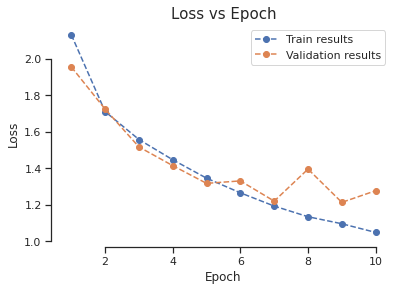

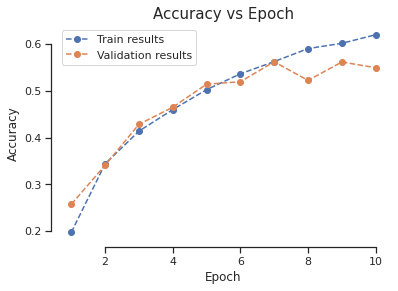

0.5623


In [15]:
# TODO train and plot with step size 1, gamma 0.1
# TODO train and plot
# Set hyperparameters
lr = 1e-1  # learning rate
num_epochs = 10  # number of epochs (a bit smaller than suggested...)

# Initialize
model = ResNet(num_channels, num_classes)
model.to(device)
optimizer_res = optim.Adam(model.parameters(), lr=lr)
schduler = torch.optim.lr_scheduler.StepLR(optimizer_res, step_size=1, gamma=0.1)
loss_fct_res  = nn.CrossEntropyLoss()
early_stop = EarlyStopper(patience=3)
# Fit the Model: training and validation
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model=model, 
                                                                                      optimizer=optimizer_res, 
                                                                                      loss_function=loss_fct_res, 
                                                                                      device=device, 
                                                                                      num_epochs=num_epochs, 
                                                                                      train_dataloader=trainloader, 
                                                                                      val_dataloader=valloader, 
                                                                                      early_stopper=None, 
                                                                                      verbose=False,
                                                                                      scheduler=schduler,)
plot(f"Loss vs Epoch", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot(f"Accuracy vs Epoch", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label="saved_point")
print(max(val_accs))

In [16]:
# TODO train and plot with step size 1, gamma 0.9
# TODO train and plot
# Set hyperparameters
lr = 1e-1  # learning rate
num_epochs = 10  # number of epochs (a bit smaller than suggested...)

# Initialize
model = ResNet(num_channels, num_classes)
model.to(device)
optimizer_res = optim.Adam(model.parameters(), lr=lr)
schduler = torch.optim.lr_scheduler.StepLR(optimizer_res, step_size=1, gamma=0.9)
loss_fct_res  = nn.CrossEntropyLoss()
early_stop = EarlyStopper(patience=3)
# Fit the Model: training and validation
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model=model, 
                                                                                      optimizer=optimizer_res, 
                                                                                      loss_function=loss_fct_res, 
                                                                                      device=device, 
                                                                                      num_epochs=num_epochs, 
                                                                                      train_dataloader=trainloader, 
                                                                                      val_dataloader=valloader, 
                                                                                      early_stopper=early_stop, 
                                                                                      verbose=False,
                                                                                      scheduler=schduler,)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Finished training after 258 seconds.


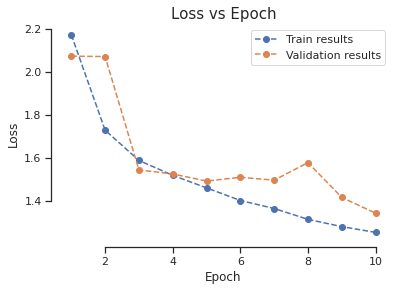

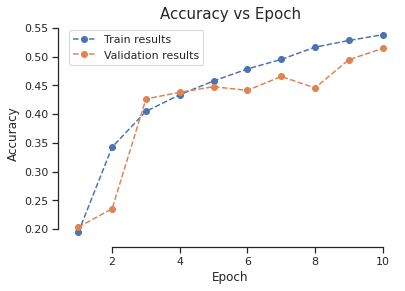

0.5142


In [17]:
plot(f"Loss vs Epoch", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot(f"Accuracy vs Epoch", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label="saved_point")
print(max(val_accs))

#### **TODO** 

Use the learning rate schedule as described in the ResNet paper (https://arxiv.org/pdf/1512.03385.pdf). Train for 30 epochs.

#### **Questions**
- Does it improve performance? 
- **Yes**
- What can you observe in the plots?
- **We see a step jump in accuracy and loss function**

**Your answers here**

In [11]:
# TODO train and plot with scheduling, optimizer, lr as in the paper.
# Set hyperparameters
lr = 1e-1  # learning rate
num_epochs = 100  # number of epochs 

# Initialize
model = ResNet(num_channels, num_classes)
model.to(device)
optimizer_res = optim.Adam(model.parameters(), lr=lr)
schduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_res, mode="max", factor=0.1, patience=3, verbose=True)
loss_fct_res  = nn.CrossEntropyLoss()
early_stop = EarlyStopper(patience=8)
# Fit the Model: training and validation
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model=model, 
                                                                                      optimizer=optimizer_res, 
                                                                                      loss_function=loss_fct_res, 
                                                                                      device=device, 
                                                                                      num_epochs=num_epochs, 
                                                                                      train_dataloader=trainloader, 
                                                                                      val_dataloader=valloader, 
                                                                                      early_stopper=early_stop, 
                                                                                      verbose=False,
                                                                                      scheduler=schduler,)


Epoch    16: reducing learning rate of group 0 to 1.0000e-02.
Epoch    24: reducing learning rate of group 0 to 1.0000e-03.
Epoch    30: reducing learning rate of group 0 to 1.0000e-04.
Epoch    34: reducing learning rate of group 0 to 1.0000e-05.
Finished training after 904 seconds.


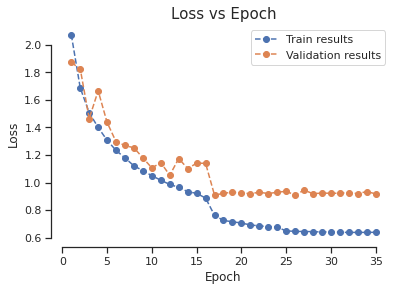

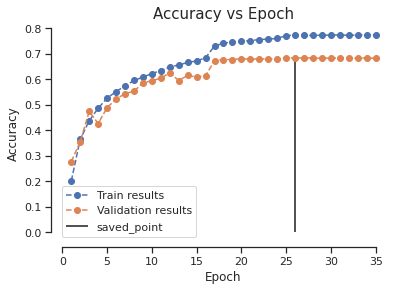

0.6846


In [12]:
plot(f"Loss vs Epoch", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot(f"Accuracy vs Epoch", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=early_stop.last_best_value, extra_pt_label="saved_point")
print(early_stop.last_best_value)

## [7. Optional LR-Scheduling]

#### **TODO**
- try two more scheduler: ExponentialLR and ReduceLROnPlateau 
- vary the parameters, which work best?
- does it improve performance compared to no scheduler?
- does it improve performance compared to StepLR?

**Your answers here**

In [ ]:
# TODO train and plot

## [8. Optional Transfer Learning]

### **TODO**

- load a pretrained ResNet from torchvision
- freeze the parameters so that the gradients are not computed
- replace the last fully-connected layer
- fine-tune the model
- plot the results again and compare to approaches before
    - is a better performance reached? why/why not?
    - does it take more/less time to fine-tune compared to train a resnet?

**Your answers here**

In [ ]:
# TODO do transfer learning with resnet on cifar10